In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
#Input fits files
file_fcal = "../LRIS data/1D spectra/OIIB146m-4_w7_fcal.fits"
file_iraf = "../LRIS data/1D spectra/OIIB146m-4_w7_iraf.fits"
file_iraf_E = "../LRIS data/1D spectra/OIIB146m-4_w7_iraf_E.fits"

In [3]:
#Extract data from fits files
fits_fcal = fits.open(file_fcal)
fits_iraf = fits.open(file_iraf)
fits_iraf_E = fits.open(file_iraf_E)

wave = fits_fcal[0].data #Wavelength
flux = fits_iraf[0].data #Flux
err = fits_iraf_E[0].data #Flux uncertainty

In [4]:
#Add a mask on wavelengths from 3700A to 3900A
mask = np.where((wave>3700)&(wave<3900))

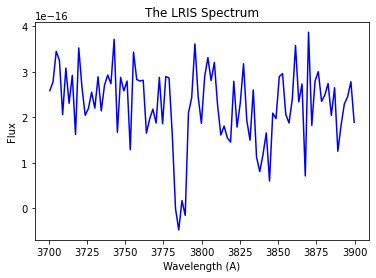

In [5]:
#Plot the LRIS spectrum
plt.figure()
plt.tight_layout()

plt.title("The LRIS Spectrum")
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.plot(wave[mask],flux[mask],color='b')  

In [6]:
#The systemic redshift
z_cos = 1.48260

# Absorber 1

In [19]:
# Doublet ratio = F(red) / F(blue)
dr1 = 0.6

In [20]:
# Vacuum setting
# Blue line
wb = 1548.204
# Red line
wr = 1550.781

In [21]:
# w0:  wavelength where continuum level is y0
w0 = 3775.0

In [22]:
def func(x, z, sigma, a, m, y0):  
    return (-a * np.exp(-(x - wb * (1.+z_cos) * (1.+z))**2 / (2. * sigma **2))
           - dr1 * a * np.exp(-(x - wr * (1.+z_cos) * (1.+z))**2 / (2. * sigma **2)) + m * (x - w0) + y0)

In [23]:
z_ab1 = -4700.0/2.99792e5
z_ab1

-0.015677536425254844

In [24]:
guess = np.array([-0.0156, 2.16, 3.6e-16, 0, 2.6e-16])  # redshift, sigma (A), amplitude, continuum slope, continuum 

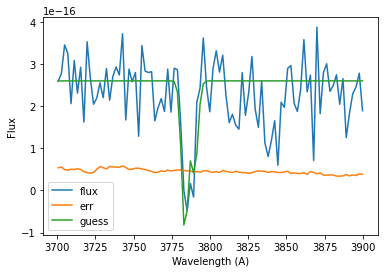

In [25]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")

yguess = func(wave,guess[0],guess[1],guess[2],guess[3],guess[4])
plt.plot(wave[mask],flux[mask],label='flux') 
plt.plot(wave[mask], err[mask], label='err')
plt.plot(wave[mask], yguess[mask], label='guess')
plt.legend()

In [26]:
# Fit with SciPy
p, pcov = curve_fit(func, wave[mask], flux[mask], guess, err[mask])
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')

Fit Completed


In [27]:
#Results
print('redshift = '+str(p[0])+', sigma = '+str(p[1])+', amplitude = '+str(p[2])
      +', continuum slope = '+str(p[3])+', continuum = '+str(p[4]))
perr

redshift = -0.01560229815454156, sigma = 2.1517285877543837, amplitude = 2.989137579368417e-16, continuum slope = -2.314719003788636e-19, continuum = 2.458495846924886e-16


array([1.54415607e-04, 4.69710601e-01, 6.36630217e-17, 1.22604147e-19,
       8.80209093e-18])

In [28]:
#Resultant blushift
v = -p[0]*2.99792e5
v_std = perr[0]*2.99792e5
print('Speed = '+str(v)+' ± '+str(round(v_std/100,1)*100)+' km/s')
#Resultant sigma
print('Sigma = '+str(p[1])+' ± '+str(round(perr[1],1))+' A')
#Resultant amplitude
print('Amplitude = '+str(p[2])+' ± 0.6e-16 erg*s^(-1)*cm^(-2)*A^(-1)')
#Resultant continuum slope
print('Continuum slope = '+str(p[3])+' ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-2)')
#Resultant continuum flux
print('Continuum flux = '+str(p[4])+' ± 0.09e-16 erg*s^(-1)*cm^(-2)*A^(-1)')

Speed = 4677.444168346324 ± 50.0 km/s
Sigma = 2.1517285877543837 ± 0.5 A
Amplitude = 2.989137579368417e-16 ± 0.6e-16 erg*s^(-1)*cm^(-2)*A^(-1)
Continuum slope = -2.314719003788636e-19 ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-2)
Continuum flux = 2.458495846924886e-16 ± 0.09e-16 erg*s^(-1)*cm^(-2)*A^(-1)


In [29]:
# Calculate 'Goodness of Fit'
model = func(wave[mask],p[0],p[1],p[2],p[3],p[4])
term = ((flux[mask]-model) / err[mask])**2  
dof = wave[mask].size - guess.size
chi2 = np.sum(term) / dof
chi2

2.4912798675167847

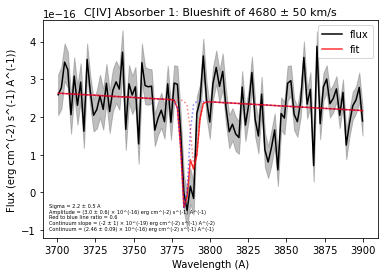

In [30]:
## Plot the results
yfit = func(wave[mask],p[0],p[1],p[2],p[3],p[4])
yblue = lambda x, z, sigma, a, m, y0:       -a * np.exp(-(x - wb * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0
yred  = lambda x, z, sigma, a, m, y0:  -dr1 * a * np.exp(-(x - wr * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0

fig = plt.figure()
plt.tight_layout()
plt.title("C[IV] Absorber 1: Blueshift of 4680 ± 50 km/s", fontsize = 11)
plt.text(3695, -1e-16, "Sigma = 2.2 ± 0.5 A \nAmplitude = (3.0 ± 0.6) × 10^(-16) erg cm^(-2) s^(-1) A^(-1) \nRed to blue line ratio = 0.6" 
         +"\nContinuum slope = (-2 ± 1) × 10^(-19) erg cm^(-2) s^(-1) A^(-2) \nContinuum = (2.46 ± 0.09) × 10^(-16) erg cm^(-2) s^(-1) A^(-1)", fontsize = 5)
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (erg cm^(-2) s^(-1) A^(-1))")
plt.plot(wave[mask],flux[mask],'k',label='flux')
plt.plot(wave[mask],yfit,'r',label='fit',alpha=0.8)
plt.plot(wave[mask],yblue(wave[mask],p[0],p[1],p[2],p[3],p[4]), 'b:',alpha=0.5)
plt.plot(wave[mask],yred(wave[mask],p[0],p[1],p[2],p[3],p[4]), 'r:',alpha=0.5)
plt.fill_between(wave[mask], flux[mask]-err[mask], flux[mask]+err[mask], color='grey', alpha=0.5)
plt.legend()
plt.savefig('AB1_dr=0.6.pdf')
# plt.plot(wave,yguess,'k:')

# Absorber 2

In [223]:
# Doublet ratio = F(red) / F(blue)
dr2 = 1.1

In [224]:
def func(x, z, sigma, a, m, y0):  
    return (-a * np.exp(-(x - wb * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2))
           - dr2 * a * np.exp(-(x - wr * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0)

In [225]:
z_ab2 = -420.0/2.99792e5
z_ab2

-0.0014009713401291562

In [226]:
guess = np.array([-0.0014, 2.0, 1.8e-16, 0, 2.6e-16])  # redshift, sigma (A), amplitude, continuum slope, continuum 

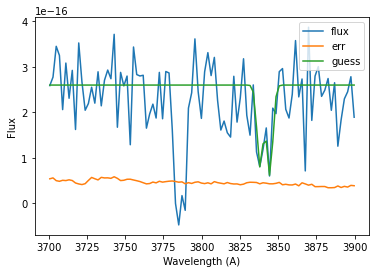

In [227]:
#Sanity check
plt.figure()
plt.tight_layout()
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")

yguess = func(wave,guess[0],guess[1],guess[2],guess[3],guess[4])
plt.plot(wave[mask],flux[mask],label='flux') 
plt.plot(wave[mask], err[mask], label='err')
plt.plot(wave[mask], yguess[mask], label='guess')
plt.legend()

In [228]:
# Fit with SciPy
p, pcov = curve_fit(func, wave[mask], flux[mask], guess, err[mask])
perr = np.sqrt(np.diag(pcov))
print ('Fit Completed')
perr

Fit Completed


array([2.03732900e-04, 5.83634973e-01, 5.29740094e-17, 1.40227693e-19,
       9.74936307e-18])

In [229]:
#Results
print('redshift = '+str(p[0])+', sigma = '+str(p[1])+', amplitude = '+str(p[2])
      +', continuum slope = '+str(p[3])+', continuum = '+str(p[4]))
perr

redshift = -0.0015278502608406757, sigma = 1.6840273999901565, amplitude = 1.5321088620602595e-16, continuum slope = -8.474370377507577e-20, continuum = 2.356113082920432e-16


array([2.03732900e-04, 5.83634973e-01, 5.29740094e-17, 1.40227693e-19,
       9.74936307e-18])

In [230]:
#Resultant blushift
v = -p[0]*2.99792e5
v_std = perr[0]*2.99792e5
print('Speed = '+str(v)+' ± '+str(round(v_std/100,1)*100)+' km/s')
#Resultant sigma
print('Sigma = '+str(p[1])+' ± '+str(round(perr[1],1))+' A')
#Resultant amplitude
print('Amplitude = '+str(p[2])+' ± 0.5e-16 erg*s^(-1)*cm^(-2)*A^(-1)')
#Resultant continuum slope
print('Continuum slope = '+str(p[3])+' ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-2)')
#Resultant continuum flux
print('Continuum flux = '+str(p[4])+' ± 0.1e-16 erg*s^(-1)*cm^(-2)*A^(-1)')

Speed = 458.03728539794787 ± 60.0 km/s
Sigma = 1.6840273999901565 ± 0.6 A
Amplitude = 1.5321088620602595e-16 ± 0.5e-16 erg*s^(-1)*cm^(-2)*A^(-1)
Continuum slope = -8.474370377507577e-20 ± 1e-19 erg*s^(-1)*cm^(-2)*A^(-2)
Continuum flux = 2.356113082920432e-16 ± 0.1e-16 erg*s^(-1)*cm^(-2)*A^(-1)


In [231]:
# Calculate 'Goodness of Fit'
model = func(wave[mask],p[0],p[1],p[2],p[3],p[4])
term = ((flux[mask]-model) / err[mask])**2  
dof = wave[mask].size - guess.size
chi2 = np.sum(term) / dof
chi2

3.242781356286942

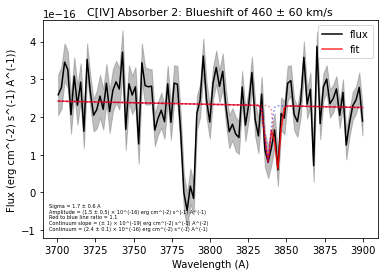

In [232]:
# Plot the results
yguess = func(wave[mask],guess[0],guess[1],guess[2],guess[3],guess[4])
yfit = func(wave[mask],p[0],p[1],p[2],p[3],p[4])
yblue = lambda x, z, sigma, a, m, y0:       -a * np.exp(-(x - wb * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0
yred  = lambda x, z, sigma, a, m, y0:  -dr2 * a * np.exp(-(x - wr * (1.+z_cos) * (1.+ z))**2 / (2. * sigma **2)) + m * (x - w0) + y0

fig = plt.figure()
plt.title("C[IV] Absorber 2: Blueshift of 460 ± 60 km/s", fontsize = 11)
plt.text(3695, -1e-16, "Sigma = 1.7 ± 0.6 A \nAmplitude = (1.5 ± 0.5) × 10^(-16) erg cm^(-2) s^(-1) A^(-1) \nRed to blue line ratio = 1.1" 
         +"\nContinuum slope = (± 1) × 10^(-19) erg cm^(-2) s^(-1) A^(-2) \nContinuum = (2.4 ± 0.1) × 10^(-16) erg cm^(-2) s^(-1) A^(-1)", fontsize = 5)
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux (erg cm^(-2) s^(-1) A^(-1))")
plt.plot(wave[mask],flux[mask],'k',label='flux')
plt.plot(wave[mask],yfit,'r',label='fit',alpha=0.8)
plt.plot(wave[mask],yblue(wave[mask],p[0],p[1],p[2],p[3],p[4]), 'b:',alpha=0.5)
plt.plot(wave[mask],yred(wave[mask],p[0],p[1],p[2],p[3],p[4]), 'r:',alpha=0.5)
plt.fill_between(wave[mask], flux[mask]-err[mask], flux[mask]+err[mask], color='grey', alpha=0.5)
plt.legend()
plt.savefig('AB2_dr=1.1.pdf')
# plt.plot(wave,yguess,'k:')